# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [1]:
# script params
EXEC: bool = True

In [3]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs

# specify number of threads
#!export OMP NUM THREADS=2 ; ./prog
#!nvcc -g -o bin/tp_cuda_part_1_pi_basic tp_cuda_part_1_pi_basic.cu -O3 -Xcompiler -rdynamic -lineinfo

!nvcc -o bin/tp_cuda_part_1_pi_multiblock_1_threadperblock tp_cuda_part_1_pi_multiblock_1_threadperblock.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread tp_cuda_part_1_pi_multithread.cu -O3
!nvcc -o bin/tp_cuda_part_1_pi_multithread_shared tp_cuda_part_1_pi_multithread_shared.cu -O3

# cuda-memcheck ./bin/tp_cuda_part_1_pi_basic -T 1000 -N 100000

### Performance evaluation

In [13]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'D': int,
    'N': int,
    'runtime' : float
}

matrix_params: list[dict[str, int]] = [
    {"B": 100, "T": 64, "N": 1},
]

color_class = {
    "threadperblock": "red",
    "multithread": "green",
    "multithread_shared": "blue",
    "multithread_reduction": "purple",
}

repeats = 10

[100000, 10000000, 1000000000]


In [14]:
import os
import subprocess

try:
    os.remove(csv_result_file)
except OSError:
    pass

# create csv file
f = open(csv_result_file, "w")
f.write(",".join(csv_headers.keys()) + "\n")
f.close()

# execute the programs
def run_program(program_filepath: str, index: int):
    args = (program_filepath, 
        "-B", str(matrix_params[i]["B"]), 
        "-T", str(matrix_params[i]["T"]),
        "-N", str(matrix_params[i]["N"])
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

for _ in range(repeats):
    for i in range(0,len(matrix_params)):
        args = ("./bin/tp_cuda_part_1_pi_multiblock_1_threadperblock", 
            "-B", str(matrix_params[i]["B"]), 
            "-N", str(matrix_params[i]["N"])
        )
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()
        
        run_program("bin/tp_cuda_part_1_pi_multithread", i)


### Performance analysis

,version,nb_threads,num_steps,runtime
0,critical,1,100000,0.001823
1,atomic,1,100000,0.000622
2,reduction,1,100000,0.000126
3,critical,1,100000,0.000981
4,atomic,1,100000,0.000479
5,reduction,1,100000,0.000131
6,critical,1,100000,0.000978
7,atomic,1,100000,0.000482
8,reduction,1,100000,0.000125
9,critical,1,100000,0.000979


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


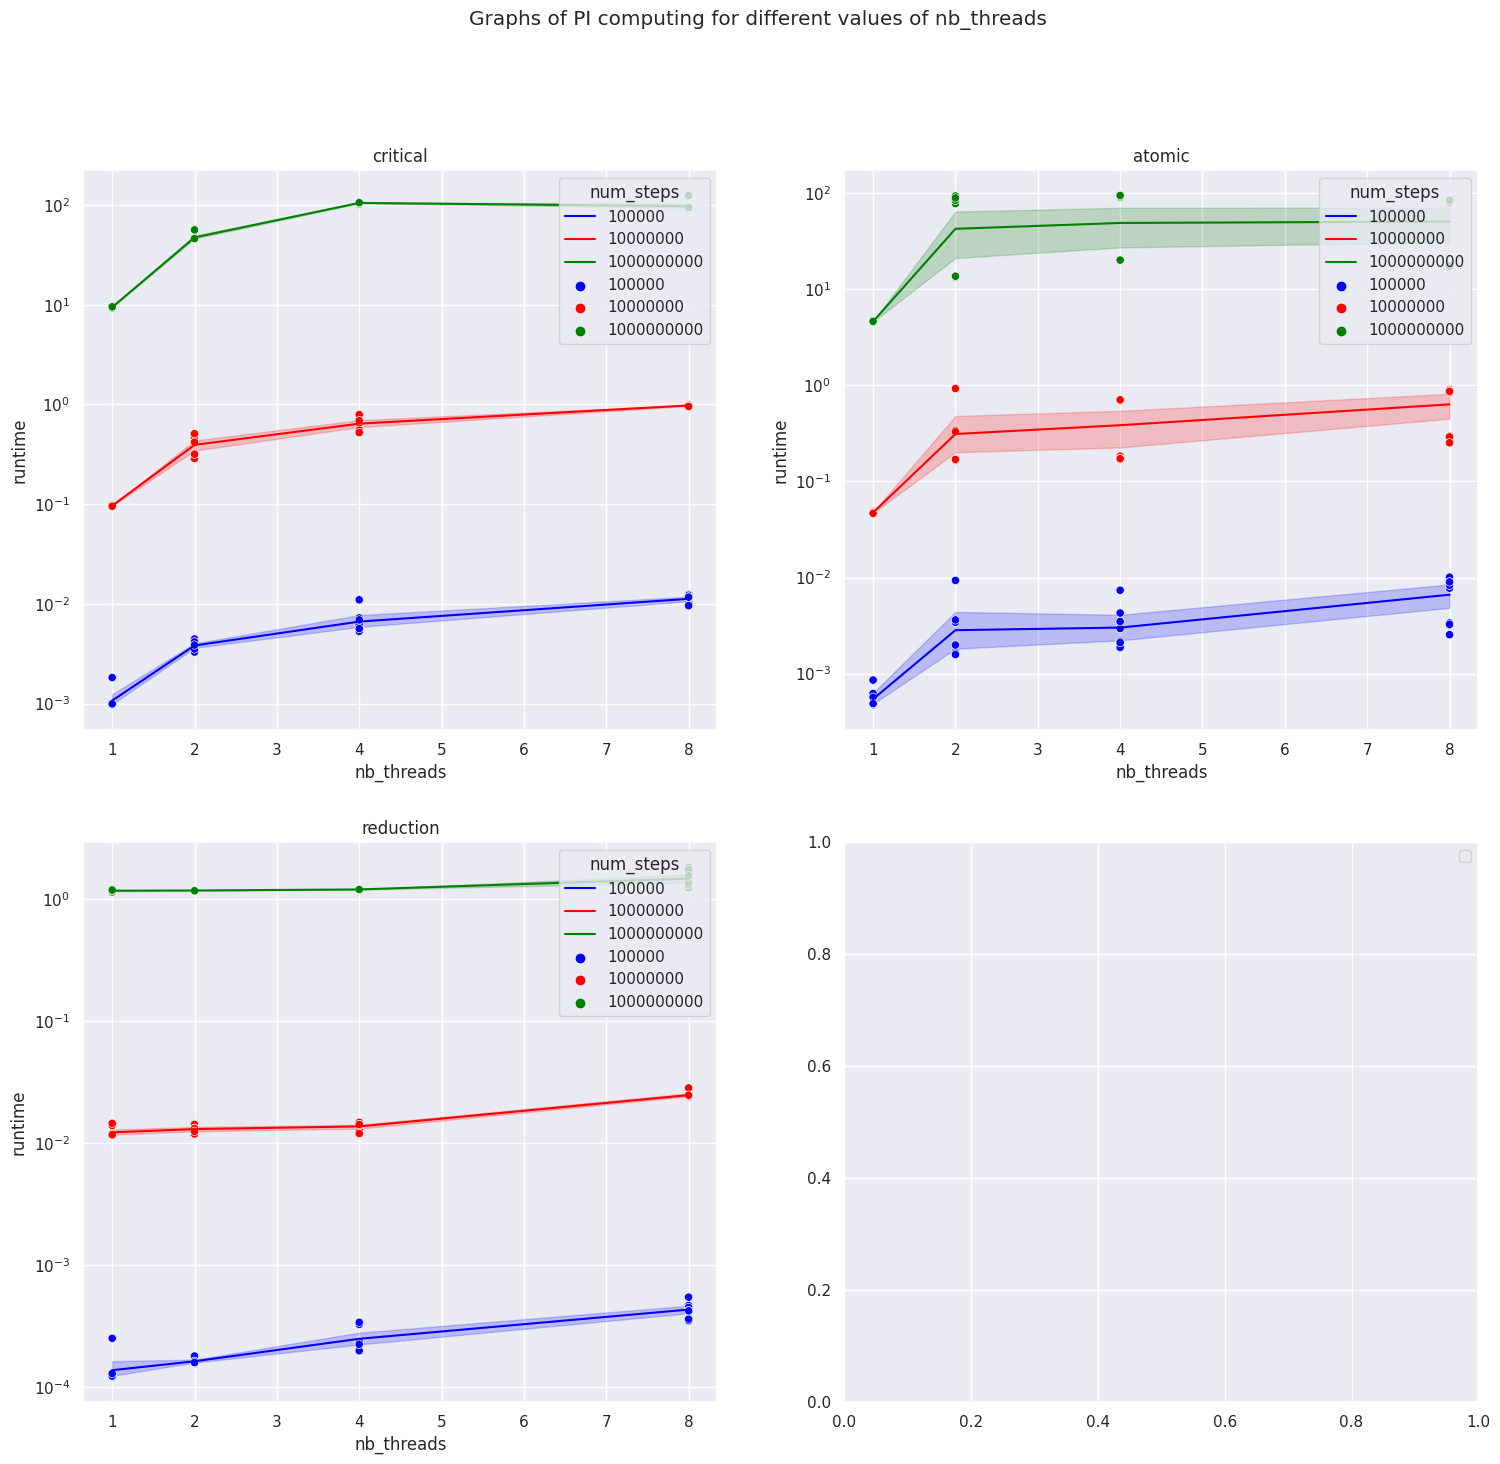

In [22]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]



# display the graph
def display_graph(D: int, df):
    fig, ax = plt.subplots(figsize=(18,16))
    fig.suptitle(f"Superposed Graphs of Chained Matrix multiplication for different precisions, with square matrices of size {D}x{D}")

    for i in range(0, len(color_class.keys())):
        # print version graph data
        graph_version = list(color_class.keys())[i]
        df_plot_0 = df[df['version'] == graph_version]

        g0 = sns.lineplot(
            ax=ax,
            data=df_plot_0, 
            x="N",
            y="runtime", 
            hue="version",
            palette=color_class,
            style="version",
        )
        g0.set(yscale="log")
        g0.set(xlabel="Matrix dimensions N=M=P", ylabel="runtime (s)")
        g00 = sns.scatterplot(
            ax=ax,
            data=df_plot_0, 
            x="N",
            y="runtime", 
            hue="version",
            palette=color_class,
            legend=False,
        )
        g00.set(yscale="log")

    plt.legend()
    plt.show()



# display graphs for D = 100
df_100 = df[df.D == 100]
df_100 = df_100.sort_values(by=['N'])
df_100 = df_100.reset_index(drop=True)
df_100 = df_100.drop(columns=['D'])
display_graph(100, df_100)

# display graphs for D = 1000
df_1000 = df[df.D == 1000]
df_1000 = df_1000.sort_values(by=['N'])
df_1000 = df_1000.reset_index(drop=True)
df_1000 = df_1000.drop(columns=['D'])
display_graph(1000, df_1000)


### Discussion